<b>
<p>
<center>
<font size='5'>
Shoppee - Price Match Guarantee
</font>
</center>
</p>

<p>
<center>
<font size='4'>
Machine Learning I: Final Project
</font>
</center>
</p>
    
<p>
<center>
<font size='4'>
Developed by: Jake Lieberfarb, Nick Blackmore, Christopher Taylor
</font>
</center>
</p>

<p>
<center>
<font size='3'>
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size='3'>
Instructor: Dr. Yuxiao Huang
</font>
</center>
</p>
</b>



## Introduction
  For our Final Project, we used the Shopee- Price Match Guarantee dataset from [Kaggle](https://www.kaggle.com/c/shopee-product-matching). Shopee is an e-commerce company located in Southeast Asia, Brazil, Mexico and Taiwan. The goal of this project was to develop a machine learning model that would effectively match similar products based on their text titles and images. The company is known for its “Lowest Price Guaranteed'' for the products listed on its [website](https://shopee.com/). Having an effective model that can group similar products should be helpful in finding the best price for consumers. In order to assist in optimizing the Shopee algorithm, A convolution neural network (CNN) and Tf-Idf + Cosine Similiarity were developed to match products based on their respective images and texts. Then used Stochastic Gradient Descent Classifier model to stack the models in a final result. 


In [ ]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive/')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/MyDrive/Colab Notebooks/DATS 6202 Final Project/'

# Get the absolute path of the deep utilities folder
abspath_util_deep = '/content/drive/MyDrive/Colab Notebooks/DATS 6202 Final Project/utilities/'

images_path = '/content/drive/MyDrive/Colab Notebooks/DATS 6202 Final Project/train_images/'

Mounted at /content/drive/


In [ ]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras

# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2

# Part 1: Reading In the Data



In [ ]:
train = pd.read_csv(abspath_curr + 'train.csv')
train.shape

(34250, 5)

In [ ]:
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


## Overview and Description of Dataset:
Before we did any modeling, we had to retrieve, process, and clean the data. There were five files downloaded from the kaggle competition site which were the ‘train_images’ folder, ‘test_images’ folder, ‘sample_submission.csv’, ‘test.csv’, and ‘train.csv’. The ‘train_images’ folder contained 34250 jpg images and labels. The ‘train.csv’ contained the labels for the 34250 images, and titles for the images. Our data set has two key feautures: image and title, and one target: label_group. The image represents an image of the product, and the title is a user-entered decription of the product. Our goal is to use the image and title to classify the products into the correct group.


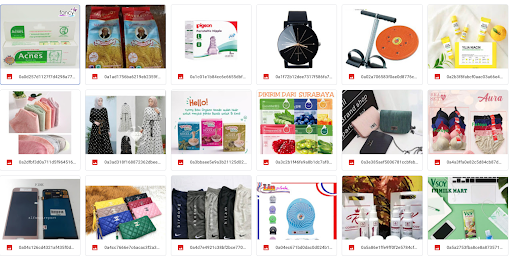

*(Figure 1:train_image Example)*


The images from the ‘train_images’ folder  were displayed with their jpg labels (figure 1). Each image is very unique and it was understandable as to why there were so many classes.  Originally there were 11014 different categories to predict, but many of these categories only had two products in them. Therefore, a threshold of three products within each category was established as it would be the minimum we could split into a train, validation, and test set for stratified sampling. Once this criteria was implemented, the number of categories dropped down to 4035, with 20292 total samples. The target variable was introduced as ‘label_group’.


In [ ]:
# Number of categories to predict
train['label_group'].unique().shape

(11014,)

In [ ]:
# Each category has a range of 2 to 51 samples
train['label_group'].value_counts()

994676122     51
159351600     51
562358068     51
3113678103    51
1163569239    51
              ..
3996065489     2
517023446      2
2101581536     2
3460538113     2
3927456083     2
Name: label_group, Length: 11014, dtype: int64

## 1a) Removing Categories that have only two samples.
This will improve the accuracy of our model and ensure that the dataset has a reasonable size.

In [ ]:
# Creating the dataframe for only values that have3 or more categories
model_values_ind = pd.Series(train['label_group'].value_counts().iloc[:4035]).index
train = train[train['label_group'].isin(model_values_ind)]
train.shape

(20292, 5)

In [ ]:
train['label_group'].unique().shape

(4035,)

In [ ]:
train.head()

,posting_id,image,image_phash,title,label_group
5,train_2464356923,0013e7355ffc5ff8fb1ccad3e42d92fe.jpg,bbd097a7870f4a50,CELANA WANITA (BB 45-84 KG)Harem wanita (bisa...,2660605217
6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137
8,train_86570404,0019a3c6755a194cb2e2c12bfc63972e.jpg,ea9af4f483249972,"[LOGU] Tempelan kulkas magnet angka, tempelan ...",2359912463
10,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2462407944
11,train_2496690777,001e11145b8e9bf5ac51110c0fdd8697.jpg,eab5c295966ac368,PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH...,509010932


# 2: Preprocessing and Feature Engineering

### Label Encoding the Target Variable

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train['label_group'] = le.fit_transform(train['label_group'])

### Feature Engineering on the Text Data (title)
Our goal is transform the text column (title) into a feauture that can actually be fed to a supervised learning algorithm. To do this we will construct a tfidf + Cosine similiarity matrix. We will then group the similarity scores by their category using an averaging aggregation function, then take the transpose of that matrix. Our final result will be a matrix for each instance will contain the average similarity score of that instance compared to all 4035 other categories. The final preprocessed data frame contained label ids, group labels, titles, and 4035 columns for the tfidf + cosine similarity matrix.

Doing this before the train-test split does not create leakage since the average similarity can be calculated with unlabeled data. However in a real world setting this would be computationally expensive as a completely new matrix would have to be created for each sample, then the average similarity between the new sample and all the others would have to be calculated. This may be possible in practive will selective sampling for training data, but it depends on the use case.
 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def Tfidf_Cosine (data):
  tfidf_vectorizer = TfidfVectorizer()
  tfidf_matrix_train = tfidf_vectorizer.fit_transform(data)  #finds the tfidf score with normalization

  cosine_matrix = arr = np.empty((0,len(data)))

  for i in range (0,len(data)):
    if i ==  len(data):
      cosine_matrix = np.append(cosine_matrix, cosine_similarity(tfidf_matrix_train[i:], tfidf_matrix_train), axis = 0)
    else:
      cosine_matrix = np.append(cosine_matrix, cosine_similarity(tfidf_matrix_train[i:(i+1)], tfidf_matrix_train), axis = 0) 
    if i % 100 == 0:
      print(i) 

  cosine_df = pd.DataFrame(cosine_matrix)

  return cosine_df

In [ ]:
# takes roughly 1.5 hours to run. We pickled the file so it could be re-used quickly
"""cosine_matrix = Tfidf_Cosine(train['title'])
cosine_matrix.head(10)"""

"cosine_matrix = Tfidf_Cosine(train['title'])\ncosine_matrix.head(10)"

In [ ]:
#cosine_matrix.to_pickle(os.path.join(abspath_curr, f"cosine.pkl"))
cosine_matrix = pd.read_pickle(os.path.join(abspath_curr, f"cosine.pkl"))

In [ ]:
cosine_matrix.columns = train['posting_id'].tolist()
cosine_matrix['label_group'] = train['label_group'].to_list()
cosine_matrix.head()

,train_2464356923,train_1802986387,train_86570404,train_1598329973,train_2496690777,train_2771755203,train_4287573913,train_4196427721,train_2985955659,train_2961381387,train_1396146683,train_1872347548,train_249329869,train_1572286671,train_3117535609,train_2410183091,train_1449570166,train_1327117441,train_1640409557,train_2720300071,train_3906985249,train_4146813717,train_3697474443,train_476982317,train_1243594898,train_2679824623,train_3743764071,train_3497907844,train_363659042,train_3921931335,train_3453637142,train_2281183509,train_615566263,train_3663748113,train_1398921910,train_2231906914,train_3241824372,train_1734882388,train_3286978516,train_1612784649,...,train_574720564,train_2727670998,train_188164388,train_3281040022,train_4177490186,train_3240183012,train_2767483557,train_548093948,train_872266635,train_1988885725,train_2705589336,train_2840010156,train_2438146037,train_1070380494,train_579731665,train_3705197290,train_401099421,train_2321889874,train_3121063768,train_3296494606,train_862852253,train_2275332890,train_579957784,train_1805532273,train_4151188244,train_3738631799,train_4112373659,train_2051967800,train_3349791994,train_3943315801,train_2822476848,train_2176949584,train_3668806308,train_2287008377,train_992088844,train_3445757395,train_3480437118,train_614977732,train_3630949769,label_group
0,1.000000,0.0,0.0,0.096058,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.048907,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.084694,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.053123,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2497
1,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.04032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.255571,0.0,0.0,0.038068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072961,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.030802,0.0,0.0,0.0,0.0,0.0,1723
2,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2214
3,0.096058,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.140414,0.0,0.000000,0.0,0.0,0.033270,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.057615,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2305
4,0.000000,0.0,0.0,0.000000,1.0,0.955034,0.0,0.0,0.000000,0.0,0.019894,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.062269,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.048391,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,484


In [ ]:
cosine_matrix = cosine_matrix.groupby(by="label_group").mean()
target_matrix = cosine_matrix.transpose()
target_matrix.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [ ]:
print(train.shape)
print(target_matrix.shape)

(20292, 5)
(20292, 4035)


In [ ]:
# combine the matrices back into each other
feature_df = pd.concat([train, target_matrix], axis=1)
feature_df.head()

,posting_id,image,image_phash,title,label_group,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034
0,train_2464356923,0013e7355ffc5ff8fb1ccad3e42d92fe.jpg,bbd097a7870f4a50,CELANA WANITA (BB 45-84 KG)Harem wanita (bisa...,2497,0.080954,0.000000,0.053278,0.000000,0.0,0.060207,0.0,0.0,0.009984,0.0,0.0,0.044597,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.059527,0.007641,0.000000,0.0,0.0,0.0,0.0,0.0,0.057111,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.029413,0.00493,0.0,0.0,0.018273,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.010543,0.0,0.000000,0.0,0.0,0.0,0.0,0.050839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.029868,0.0,0.0,0.0,0.00000
1,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1723,0.019320,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.092331,0.0,0.0,0.000000,0.0,0.0,0.006449,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.015492,0.0,0.013667,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.013345,0.0,0.0,0.0,0.01154
2,train_86570404,0019a3c6755a194cb2e2c12bfc63972e.jpg,ea9af4f483249972,"[LOGU] Tempelan kulkas magnet angka, tempelan ...",2214,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.037231,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000
3,train_1598329973,001d7f5d9a2fac714f4d5f37b3baffb4.jpg,bec8d09693634b4b,Atasan Rajut Wanita LISDIA SWEATER,2305,0.000000,0.000000,0.030114,0.000000,0.0,0.040957,0.0,0.0,0.000000,0.0,0.0,0.021110,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.013484,0.00000,0.0,0.0,0.012431,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012070,0.0,0.0,0.0,0.00000
4,train_2496690777,001e11145b8e9bf5ac51110c0fdd8697.jpg,eab5c295966ac368,PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH...,484,0.049743,0.002562,0.000000,0.015049,0.0,0.022129,0.0,0.0,0.000000,0.0,0.0,0.004840,0.0,0.0,0.000000,0.0,0.030459,0.02009,0.000000,0.000000,0.004428,0.0,0.0,0.0,0.0,0.0,0.012539,0.036671,0.0,0.0,0.0,0.008036,0.0,0.010416,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.006592,0.0,0.0,0.0,0.0,0.000000,0.0,0.005242,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017725,0.009129,0.0,0.0,0.0,0.00000


## Adding the path to the Image Column

In [ ]:
# add the full path of the file to our dataframe
def add_path(img_name):
  return images_path + img_name

feature_df['image'] = feature_df['image'].apply(add_path)
feature_df['image'].head()

0    /content/drive/MyDrive/Colab Notebooks/DATS 62...
1    /content/drive/MyDrive/Colab Notebooks/DATS 62...
2    /content/drive/MyDrive/Colab Notebooks/DATS 62...
3    /content/drive/MyDrive/Colab Notebooks/DATS 62...
4    /content/drive/MyDrive/Colab Notebooks/DATS 62...
Name: image, dtype: object

## Dropping the image=phash column and creating lists of training and text columns

In [ ]:
#Change the column names
feature_df.drop('image_phash', axis=1, inplace=True)

In [ ]:
target = 'label_group'
train_cols = [col for col in feature_df.columns if col != target]
text_cols = [col for col in feature_df.columns if col not in [target, 'image', 'title', 'posting_id']]

## Train test split
Once the data was processed, it was split into train and test data. The original ‘test.csv’ only contained 3 images so the Tfidf dataframe was split into 60% train, and 40% test. For the testing set, 40% was selected as its size as the researchers were employing a stratified sampling method. This stratified sampling ensured that the categories in the training and testing data were the same, and that they each included all 4045 categories. To account for the available RAM on the researchers hard drives, weights were calculated for the different classes as an alternative to oversampling. While oversampling is generally preferred, it was one of the several concessions we had to make in terms our computational limitations.


In [ ]:
def execute_train_test_split(X, y):
  # Splitting the data into training and testing

  from sklearn.model_selection import train_test_split

  # train-test-val split of .
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, stratify=y)

  print("Just to be sure that the stratification works, the number of samples in the testing data is:", len(np.unique(y_train)), ", and the number of samples is the test set is:", len(np.unique(y_test)))
  print("This eliminates the need for us to check if there are unfamiliar values in the training and testing data.")
  return X_train, X_test, y_train, y_test

#X_train, X_test, y_train, y_test = execute_train_test_split(feature_df[train_cols], feature_df[target])

In [ ]:
# the split data was stored in pickle files to optimize R&D.
"""# pickling the train-test split
X_train.to_pickle(os.path.join(abspath_curr, f"x_train.pkl"))
X_test.to_pickle(os.path.join(abspath_curr, f"x_test.pkl"))
y_train.to_pickle(os.path.join(abspath_curr, f"y_train.pkl"))
y_test.to_pickle(os.path.join(abspath_curr, f"y_test.pkl"))"""

X_train = pd.read_pickle(os.path.join(abspath_curr, f"x_train.pkl"))
X_test = pd.read_pickle(os.path.join(abspath_curr, f"x_test.pkl"))
y_train = pd.read_pickle(os.path.join(abspath_curr, f"y_train.pkl"))
y_test = pd.read_pickle(os.path.join(abspath_curr, f"y_test.pkl"))

total_classes = len(np.unique(y_train))

## Converting Images into a Tensorflow Dataset

In [ ]:
#function to decode the files in the dataframe. Used to make to tensorflow dataset.
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_image(image_string)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

In [ ]:
#function to create the tensorflow dataset
def create_tf_dataset(X, y, batch_size=1):
  # the data is not shuffled so there it is consistent with the train test split
  batch_size=1
  files = X['image'].tolist()
  labels = y.tolist() 
  images = tf.constant(files) 
  labels = tf.constant(labels) 
  dataset = tf.data.Dataset.from_tensor_slices((images, labels))
  dataset = dataset.map(parse_function).batch(batch_size)

  return dataset

In [ ]:
# Creating the image datasets
image_train = create_tf_dataset(X_train, y_train)
image_test = create_tf_dataset(X_test, y_test)

## Calculating Class Weights (An Alternative to Oversampling)
This is in response to the imblearn oversampler not being able to handle the nested arrays that make up the image column.

Additionally, we don't have access to enough RAM to Oversample.

In [ ]:
import sklearn.utils.class_weight as class_weight

# compute weights for each class
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 1.5086741016109046, 1: 0.4310497433174013, 2: 1.5086741016109046, 3: 1.5086741016109046, 4: 0.6034696406443618, 5: 1.5086741016109046, 6: 1.5086741016109046, 7: 1.0057827344072696, 8: 1.5086741016109046, 9: 0.6034696406443618, 10: 1.0057827344072696, 11: 0.5028913672036348, 12: 1.5086741016109046, 13: 1.5086741016109046, 14: 0.7543370508054523, 15: 1.5086741016109046, 16: 1.5086741016109046, 17: 1.5086741016109046, 18: 0.7543370508054523, 19: 0.37716852540272616, 20: 0.7543370508054523, 21: 1.5086741016109046, 22: 1.5086741016109046, 23: 1.5086741016109046, 24: 1.5086741016109046, 25: 1.5086741016109046, 26: 1.5086741016109046, 27: 1.5086741016109046, 28: 1.5086741016109046, 29: 1.5086741016109046, 30: 1.5086741016109046, 31: 1.0057827344072696, 32: 0.4310497433174013, 33: 1.5086741016109046, 34: 1.5086741016109046, 35: 1.0057827344072696, 36: 0.4310497433174013, 37: 1.5086741016109046, 38: 1.5086741016109046, 39: 1.5086741016109046, 40: 1.5086741016109046, 41: 1.0057827344072696, 

# Part 3: Modeling
## CNN Image Classification

With the data successfully preprocessed, model building for the convolution neural network was introduced. The pip line for the CNN started with a pretrained ResNet50 model which implemented the weight calculations for each class. Next average pooling was introduced which contained hidden layers of Convolution, BatchNormalization and MaxPooling. The model accuracy was found to be **63.51%**.

We did consider the fact that unfreezing the pre-trained parameters could have produced a more accurate CNN, but since we are really only utlizing the CNN to transform the data combined with computing limits, we decided to use the pre-trained ResNet50 weights only.



In [ ]:
def CNN_model(image_train):

  # Add the pretrained layers
  pretrained_model = keras.applications.ResNet50(include_top=False, weights='imagenet')

  # Add GlobalAveragePooling2D layer
  average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

  # Add the output layer
  output = keras.layers.Dense(total_classes, activation='softmax')(average_pooling)

  # Get the model
  model = keras.Model(inputs=pretrained_model.input, outputs=output)

  model.summary()

  # For each layer in the pretrained model. We will not unfreeze these due to 
  # computational limits
  for layer in pretrained_model.layers:
      # Freeze the layer
      layer.trainable = False

  # Compile the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',    
                metrics=['accuracy'])
  
  # Train the model. Due to nature of the data, we will not be using a validation set. 
  # The data will be cross validated in the final model. No validation is used 
  # since we are really using the CNN as a data transformation texhnique 
  history = model.fit(image_train,
                      epochs=5,
                      class_weight=class_weights)
  return model


In [ ]:
# model = CNN_Model(image_train)
# model.save(abspath_curr + 'saved_model/my_model')

In [ ]:
model = tf.keras.models.load_model(abspath_curr + 'saved_model/my_model')
loss, accuracy = model.evaluate(image_test)

8117/8117 [==============================] - 5060s 608ms/step - loss: 4.0146 - accuracy: 0.6351


## Converting CNN Model Outputs to Class Probabilities

WE can convert the class probabilities for the CNN predictions to a dataset, so for each sample there is a corresponding feature that is the likelihood that the image belongs to a certain class.

In [ ]:
def make_probability_df(probs):
  cols = [str(i)+"_cnn" for i in range(len(probs[0]))]
  df = pd.DataFrame(probs, columns=cols)
  return df

# Below are the steps for creating the full datasets. Once they were created they were pickled
# so there is no need to run this code every time.

"""y_probs_train = model.predict(image_train)
y_probs_test = model.predict(image_test)"""

"""train_probs_df = make_probability_df(y_probs_train)
train_probs_df.reset_index(drop=True, inplace=True)
test_probs_df = make_probability_df(y_probs_test)
test_probs_df.reset_index(drop=True, inplace=True)"""

"""new_X_train = X_train[text_cols]
new_X_train.reset_index(drop=True, inplace=True)
new_X_test = X_test[text_cols]
new_X_test.reset_index(drop=True, inplace=True)

full_X_train_df = pd.concat([new_X_train, train_probs_df], axis=1)
full_X_test_df = pd.concat([new_X_test, test_probs_df], axis=1)"""

"""full_X_train_df.to_pickle(os.path.join(abspath_curr, f"full_X_train_df.pkl"))
full_X_test_df.to_pickle(os.path.join(abspath_curr, f"full_X_test_df.pkl"))"""

'full_X_train_df.to_pickle(os.path.join(abspath_curr, f"full_X_train_df.pkl"))\nfull_X_test_df.to_pickle(os.path.join(abspath_curr, f"full_X_test_df.pkl"))'

In [ ]:
full_X_train_df = pd.read_pickle(os.path.join(abspath_curr, f"full_X_train_df.pkl"))
full_X_test_df = pd.read_pickle(os.path.join(abspath_curr, f"full_X_test_df.pkl"))

full_X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3995_cnn,3996_cnn,3997_cnn,3998_cnn,3999_cnn,4000_cnn,4001_cnn,4002_cnn,4003_cnn,4004_cnn,4005_cnn,4006_cnn,4007_cnn,4008_cnn,4009_cnn,4010_cnn,4011_cnn,4012_cnn,4013_cnn,4014_cnn,4015_cnn,4016_cnn,4017_cnn,4018_cnn,4019_cnn,4020_cnn,4021_cnn,4022_cnn,4023_cnn,4024_cnn,4025_cnn,4026_cnn,4027_cnn,4028_cnn,4029_cnn,4030_cnn,4031_cnn,4032_cnn,4033_cnn,4034_cnn
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,1.008338e-17,1.487476e-12,9.637976e-10,1.860365e-16,4.563434e-19,7.412086e-16,2.063311e-14,8.310542e-26,4.867039e-06,3.241095e-14,2.579759e-08,2.744048e-13,9.923995e-08,3.355556e-21,9.148146e-13,2.414162e-13,1.141855e-19,4.427648e-16,6.181746e-09,1.158963e-22,7.030046e-11,3.295559e-10,1.548415e-09,1.830741e-07,2.416320e-11,5.095701e-10,4.645281e-19,7.919141e-14,1.291134e-20,3.664661e-16,5.083521e-20,2.082444e-09,1.162226e-14,1.078425e-12,2.867957e-15,4.842213e-10,5.785950e-21,2.244260e-15,2.697577e-25,4.982687e-20
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,2.228236e-15,1.318947e-17,9.736576e-13,1.480462e-16,3.119808e-19,2.720293e-12,1.460458e-11,4.157241e-24,1.877977e-12,1.670149e-11,1.345842e-12,1.078711e-12,1.117813e-10,7.115944e-18,2.955568e-11,5.472706e-16,1.844342e-24,1.984054e-12,8.125758e-12,4.547034e-22,3.561402e-09,5.926984e-09,7.695804e-13,2.812837e-14,1.380531e-11,1.710238e-11,4.241134e-21,3.685531e-15,1.338271e-18,1.445457e-15,8.313164e-18,4.082028e-10,1.308383e-17,1.134724e-10,1.043216e-13,4.064860e-09,6.867636e-24,4.464098e-11,3.374946e-22,1.043562e-21
2,0.0,0.0,0.0,0.0,0.014808,0.0,0.0,0.000000,0.0,0.0,0.008232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028182,0.014504,0.0,0.029415,0.0,0.0,0.0,0.0,0.0,0.017413,0.002973,0.019018,0.0,0.0,...,1.125259e-24,2.799826e-19,1.030923e-18,5.327000e-18,2.740097e-18,7.944719e-18,3.498019e-14,3.053110e-22,2.686392e-17,6.631595e-14,4.678789e-17,6.276623e-17,1.476146e-14,9.047895e-24,3.504281e-15,9.380582e-17,3.792557e-24,5.737454e-16,8.296490e-15,1.567620e-20,1.036740e-17,7.084030e-15,4.615257e-17,1.660528e-17,1.732194e-13,4.526428e-14,7.414976e-21,2.890995e-19,4.182447e-29,9.455968e-15,3.771584e-22,4.375213e-15,7.773057e-20,2.198715e-19,2.290338e-17,8.300387e-14,6.107431e-27,2.753986e-15,2.735458e-27,1.229440e-19
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.036005,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,2.891123e-23,4.816562e-21,3.594482e-22,3.648155e-19,1.505324e-22,1.217720e-20,6.242020e-20,3.350850e-28,2.691039e-18,2.566842e-15,4.408446e-19,1.705510e-20,3.322827e-17,6.634451e-24,1.100354e-20,5.024276e-21,1.774779e-25,1.689901e-22,8.863299e-15,2.804773e-22,2.537027e-21,2.220064e-20,5.962483e-17,1.157525e-18,3.818790e-18,3.839201e-15,2.111745e-19,1.593747e-21,6.568560e-28,4.872141e-16,4.613924e-31,2.100971e-18,8.094061e-20,6.153879e-20,5.543019e-23,7.985483e-15,3.105373e-28,1.565337e-22,5.468128e-30,1.130682e-24
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,9.507708e-14,1.025705e-14,1.206369e-15,9.530326e-15,8.168548e-18,1.842840e-18,8.463855e-13,1.344147e-12,4.099095e-17,2.735655e-15,3.967409e-15,3.157067e-15,2.577917e-12,6.377381e-14,3.961576e-13,1.054555e-18,3.940497e-17,1.627794e-14,5.026969e-11,7.398682e-14,3.514501e-15,2.782866e-12,1.786759e-14,1.849456e-15,5.725346e-17,2.010243e-12,2.376571e-14,8.968932e-18,1.263480e-19,4.282215e-11,

# Model Stacking Component.
After transforming the data through a CNN and a TF-IDF Cosine Similarity Matrix, we will feed the new features through several other models to see how they perform.
Due to the unbalanced and high dimmensional we will be testing the model using the Stochastic Gradient Descent Classifier. By adjusting the loss function that the SGD Classifier uses, we are essentially changing the model that is used. Therefore, instead of using several different models, we will only use different loss functions for the SGD Classifier. The reason these models were selected are: 1) They are relatively efficient in terms of CPU and RAM as compared to tree based models and 2) They allow us to use class wieghts to handle imbalance (the lack of this feature ruled out a MultiLayer Perceptron).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, f1_score
import pickle
from sklearn.pipeline import Pipeline

In [ ]:
# Gives us the freedom to test several different models that utilize the 
# SGD algorithm.
models = {'sgd': SGDClassifier(class_weight=class_weights)}

In [ ]:
pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [ ]:
param_grids = {}

In [ ]:
# hinge: SVM, log: Logistc Regression
loss = ['hinge', 'log']

alpha = [10 ** -5, 10 ** -4, 10 ** -3]

penalty = ['elasticnet', 'l2', 'l1']

learning_rate = ['optimal', 'adaptive']

eta0 = [1, 10, 100] 

# Update param_grids
param_grids['sgd'] = [{'model__loss': loss,
                       'model__alpha': alpha,
                       'model__penalty': penalty,
                       'model__learning_rate': learning_rate,
                       'model__eta0': eta0}]

In [ ]:

def train_model(X, y, pipes, param_grids, iters, model_name=''):
  best_score_params_estimator_gs = []

  # For each model
  for acronym in pipes.keys():
      # GridSearchCV
      gs = RandomizedSearchCV(estimator=pipes[acronym],
                        param_distributions=param_grids[acronym],
                        n_iter=iters,
                        scoring='f1_macro', 
                        cv=2,
                        return_train_score=True,
                        verbose=100)
          
      # Fit the pipeline
      gs = gs.fit(X, y)
      
      # Update best_score_params_estimator_gs
      best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
      
      # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
      cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
      
      # Get the important columns in cv_results
      important_columns = ['rank_test_score',
                          'mean_test_score', 
                          'std_test_score', 
                          'mean_train_score', 
                          'std_train_score',
                          'mean_fit_time', 
                          'std_fit_time',                        
                          'mean_score_time', 
                          'std_score_time']
      
      # Move the important columns ahead
      cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

  # Sort best_score_params_estimator_gs in descending order of the best_score_
  best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

  # Print best_score_params_estimator_gs
  results = pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

  best_model = results.loc[0, 'best_estimator']
  
  pickle.dump(best_model, open(model_name, 'wb'))

 

## First we test the Model on Only the Tf-IDF data. 

We do this so we have a baseline. If our final model does better than both the TF-IDF model and the CNN, then that is good evidence that a model that makes use of both features is more useful than a solely text-based or image-based model.

In [ ]:
# testing the text only model and assessing accuracy
filename = os.path.join(abspath_curr, f"text_model.sav")
#train_model(full_X_train_df[text_cols], y_train, pipes, param_grids, 5, model_name=filename)

text_model = pickle.load(open(filename, 'rb'))

text_results = text_model.predict(full_X_test_df[text_cols])
print('Accuracy: ',accuracy_score(y_test, text_results), "F1 Score:", f1_score(y_test, text_results, average='macro'))

Accuracy:  0.5365282739928545 F1 Score: 0.5125718877351002


### Redefining the Parameter Grids for the Full Model. Allows us to compare SGD Logistic Regression to SGD SVM.

In [ ]:
# hinge: SVM, log: Logistc Regression
loss = ['log', 'hinge']

alpha = [10 ** -4, 10 ** -3]

penalty = ['elasticnet', 'l2', 'l1']

learning_rate = ['optimal', 'adaptive']

eta0 = [1, 10, 100] 

# Update param_grids
param_grids['sgd'] = [{'model__loss': loss,
                       'model__alpha': alpha,
                       'model__penalty': penalty,
                       'model__learning_rate': learning_rate,
                       'model__eta0': eta0}]

In [ ]:
filename = os.path.join(abspath_curr, f"final_model.sav")
#train_model(full_X_train_df, y_train, pipes, param_grids, 5, model_name=filename)

best_model = pickle.load(open(filename, 'rb'))

test_results = best_model.predict(full_X_test_df)
print('Accuracy: ',accuracy_score(y_test, test_results), "F1 Score:", f1_score(y_test, test_results, average='macro'))

Accuracy:  0.7659233707034618 F1 Score: 0.7226730413249843


In [ ]:
best_model

Pipeline(memory=None,
         steps=[('model',
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight={0: 1.5086741016109046,
                                             1: 0.4310497433174013,
                                             2: 1.5086741016109046,
                                             3: 1.5086741016109046,
                                             4: 0.6034696406443618,
                                             5: 1.5086741016109046,
                                             6: 1.5086741016109046,
                                             7: 1.0057827344072696,
                                             8: 1.5086741016109046,
                                             9: 0.6034696406443618,
                                             10: 1.0057827344072696,
                                             11: 0.5028913672036348,
                                             12: 1...
                    

# Part 4: Conclusion

Overall, we are happy with the performance of our model. Of the models we ran, the support vector machine with stochastic gradient descent optimization, elasticnet regularization, and an 'optimal' learning rate scheduler had the best performance. The combined model got an accuracy score of **~76%**, whereas models based on the CNN or TF-IDF Cosine Similarity Matrix received accuracy scores of **~65% and ~50%**, respectively. In terms of our F1 score (**~0.72**), our model is doing slightly worse than the top Kaggle scores (**~0.75**), with the caveat that we removed the classes that were probably the hardest to predict for computational purposes. 

However, there are definitely ways our model could have been improved given more resources. First, utitlizing the RAPIDS framework for GPU optimization could have reduced runtime significantly and increased the amount of data that we could process. Additionally, access to higher RAM would have drastically increased our modeling options. In industry, a model like ours would most likely need to be trained in a distributed setting.


# Part 5: Supplemental Research & Trial and Error
## Modeling Testing

This code represents the final model. We tested other models and processing techniques to ensure we arrived at a good model. Upon inspection of the title column, it was found that many of the products had different translations. Some had indonesian, Malay, and English while others just had English. Translation was implemented to better assist in classifying the products, a bar chart was constructed to understand the distributions of languages for the original and eventually the translated data. It was clear that although English was the dominant language in the dataset, the data could benefit from translation (figure 2). After English, the next most frequency languages were Indonesian, Malay, German, Italian, Spanish, and French. Google translate was introduced on the data frame and did an effective job at manipulating the data. 
After translation, English clearly became the most dominant language in the dataframe with many of the other languages not appearing over about five percent of the entire corpus (figure 3). The exact numbers on words translated was calculated as well to gage the effectiveness of google translate. The original data had 38.7912% English text and after translation it almost doubled to 66.5139%. The percentage of Indonesian text which was the second most frequent language in the original data decreased from 19.7431% to 3.2759% in the translated text data. No further translation methods were introduced as instances of mistranslation could occur with subsequent translation. When comparing the translated text versus the original text outputs of the tf-idf + Cosine similarity matrix, the accuracy of grouped items did not increase or materially fluctuate. As translation showed that it would not affect the model we chose to use the untranslated text in the final model to reduce computation time. 




 Our first text model choice was to build an RNN to predict what titles are similar. There were two key preprocessing steps for the model. First was to adjust the class imbalance, some product groups only had 3 items and others had more than 50. We chose to use class weights to solve the imbalance to keep the size of the data files down. This also required adjusting the label_group numbers start from 0 and count up. The second preprocessing step was to convert data to tensorflow that could be run through the RNN model. The model generated results with a lower accuracy than a random model (figure 5). This was most likely driven by the sheer number of classes, and the low amount of data per class. After a few attempts to tweak the model with little improvement, we did research on how best and efficiently rate text similarity and we settled on using a td-idf vectorization + cosine similarity as it was accurate, well tested, and computationally efficient. Both the RNN, and Translation model code are saved in seperate code files as part of the project package. 


## Figure Appendix

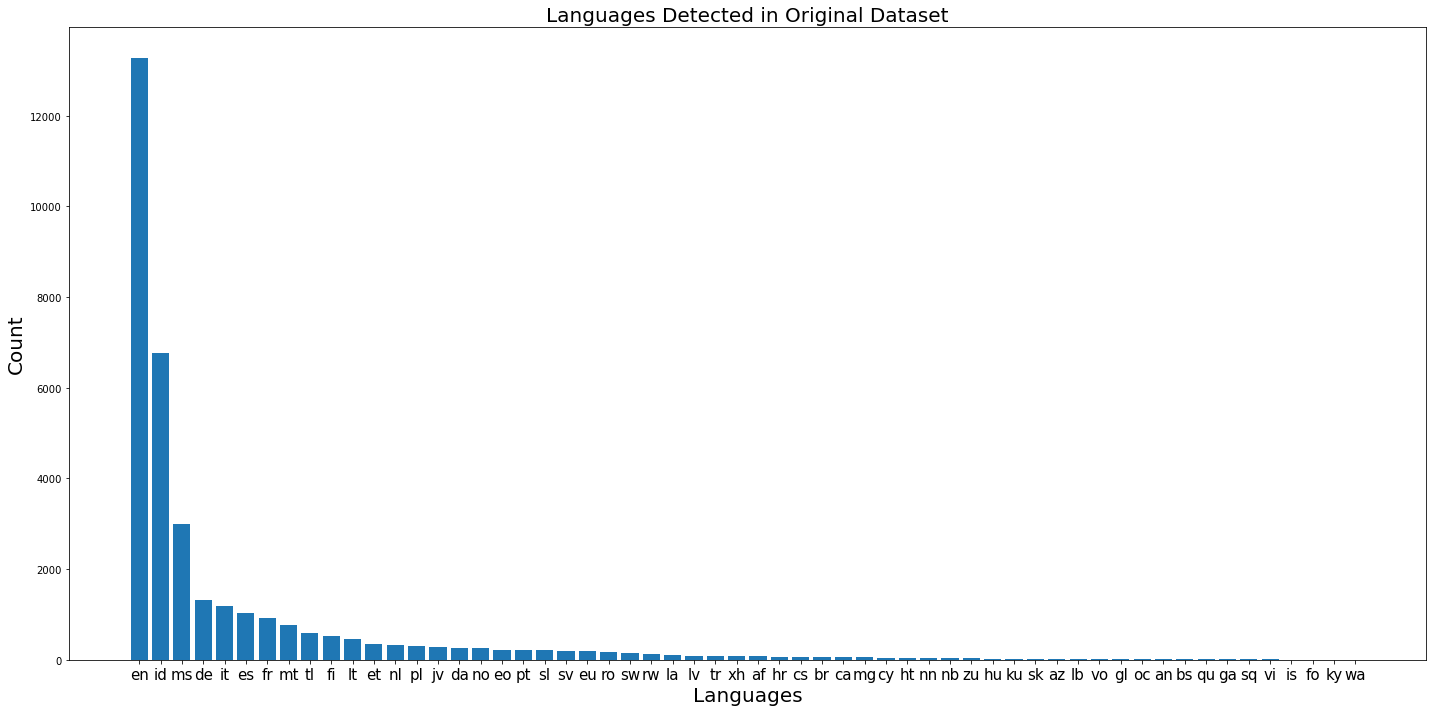

*(Figure 2: Bar Chart of Languages Detected in Original Dataset)* **bold text**

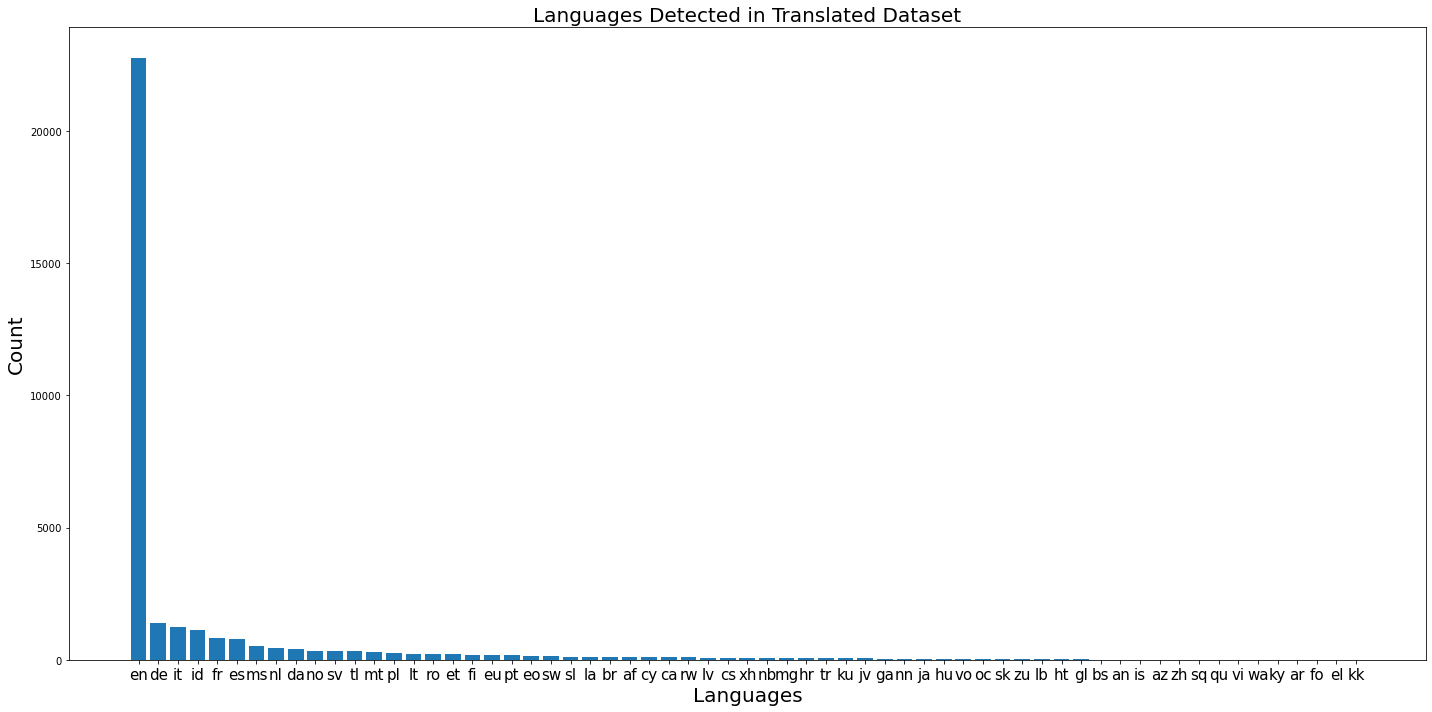

*(Figure 3: Bar Chart of Languages Detected in Original Dataset)*

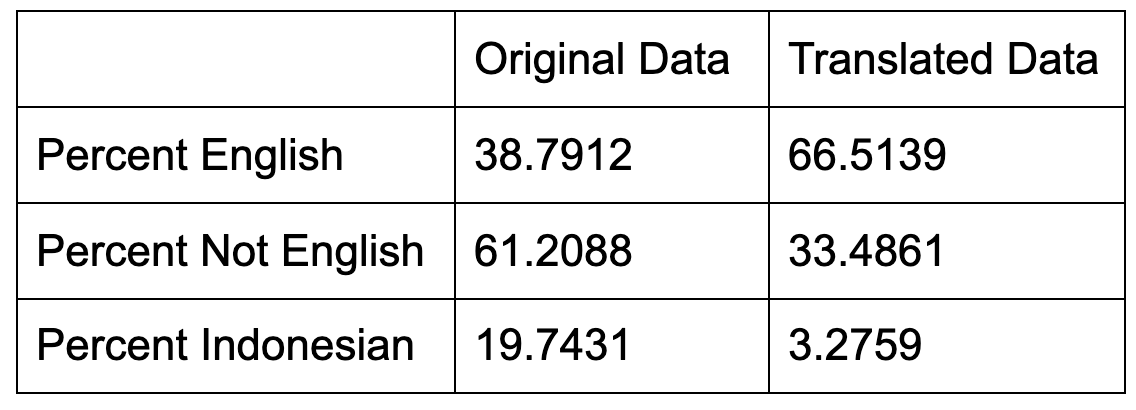

*(Figure 4: English and Indonessian Translation of Original Data)*

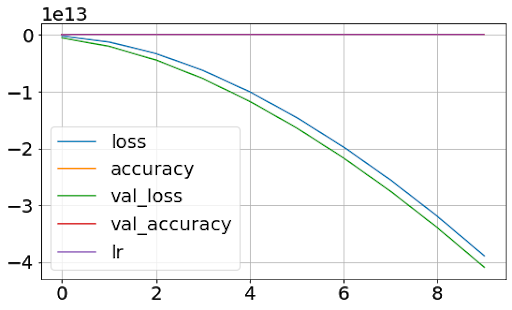

*(Figure 5: RNN Plot of Validation, Accuracy, and Loss)*